In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
import joblib
from datetime import datetime

from skimage.io import imread
from skimage.transform import resize

from sklearn import svm
from sklearn.model_selection import (
    GridSearchCV, 
    StratifiedKFold,
    cross_val_score,
    cross_validate
)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    cohen_kappa_score,
    matthews_corrcoef
)

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully!")

c:\Users\62821\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All libraries imported successfully!


In [2]:
# Setup paths
current_dir = os.getcwd()

path_dict = {
    'GANAS': os.path.join(current_dir, "Ganas"),
    'JINAK': os.path.join(current_dir, "Jinak"),
    'NON KANKER': os.path.join(current_dir, "Non Kanker")
}

Categories = ['GANAS', 'JINAK', 'NON KANKER']

print(f"📁 Working Directory: {current_dir}")
for cat, path in path_dict.items():
    exists = "✅" if os.path.exists(path) else "❌"
    print(f"{exists} {cat}: {path}")

📁 Working Directory: c:\Users\62821\Downloads\PSD - Revisi
✅ GANAS: c:\Users\62821\Downloads\PSD - Revisi\Ganas
✅ JINAK: c:\Users\62821\Downloads\PSD - Revisi\Jinak
✅ NON KANKER: c:\Users\62821\Downloads\PSD - Revisi\Non Kanker


In [3]:
# Load dataset with preprocessing
flat_data_arr = [] 
target_arr = [] 
img_stats = {'total': 0, 'valid': 0, 'grayscale': 0, 'rgb': 0, 'failed': 0}

print("\n" + "="*70)
print("📦 LOADING & PREPROCESSING DATASET")
print("="*70)
print("⚙️  Image Resolution: 224×224×3")
print("⚙️  Normalization: [0, 1] range")
print("⚙️  Auto RGB conversion")
print("="*70 + "\n")

for category in Categories:
    folder_path = path_dict[category]
    print(f'📂 Processing: {category}')
    
    if not os.path.exists(folder_path):
        print(f"❌ Folder not found: {folder_path}\n")
        continue
        
    files = [f for f in os.listdir(folder_path) 
             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    count = 0
    
    with tqdm(files, desc=f"  Loading {category}", unit="img") as pbar:
        for img in pbar:
            try:
                img_stats['total'] += 1
                img_path = os.path.join(folder_path, img)
                img_array = imread(img_path)
                
                # Handle different image formats
                if len(img_array.shape) == 2:
                    # Grayscale -> RGB
                    img_array = np.stack([img_array] * 3, axis=-1)
                    img_stats['grayscale'] += 1
                elif img_array.shape[2] == 4:
                    # RGBA -> RGB
                    img_array = img_array[:, :, :3]
                    img_stats['rgb'] += 1
                elif img_array.shape[2] == 3:
                    img_stats['rgb'] += 1
                else:
                    continue
                
                # Resize to 224x224x3
                img_resized = resize(img_array, (224, 224, 3))
                
                # Normalize to [0, 1]
                img_resized = img_resized.astype(np.float32)
                if img_resized.max() > 1:
                    img_resized = img_resized / 255.0
                
                flat_data_arr.append(img_resized.flatten())
                target_arr.append(Categories.index(category))
                count += 1
                img_stats['valid'] += 1
                
                pbar.set_postfix({'Loaded': count, 'Failed': img_stats['failed']})
                
            except Exception as e:
                img_stats['failed'] += 1
                pbar.set_postfix({'Loaded': count, 'Failed': img_stats['failed']})
                
    print(f"  ✅ {count} images loaded\n")

print("="*70)
print("📊 LOADING STATISTICS:")
print(f"  Total Images Processed: {img_stats['total']}")
print(f"  ✅ Valid Images: {img_stats['valid']}")
print(f"  📷 RGB Images: {img_stats['rgb']}")
print(f"  🔳 Grayscale->RGB: {img_stats['grayscale']}")
print(f"  ❌ Failed: {img_stats['failed']}")
print("="*70)

# Convert to numpy arrays
X = np.array(flat_data_arr)
y = np.array(target_arr)

print(f"\n📐 Dataset Shape: {X.shape}")
print(f"🎯 Target Shape: {y.shape}")
print(f"💾 Features per image: {X.shape[1]:,}")


📦 LOADING & PREPROCESSING DATASET
⚙️  Image Resolution: 224×224×3
⚙️  Normalization: [0, 1] range
⚙️  Auto RGB conversion

📂 Processing: GANAS


  Loading GANAS: 100%|██████████| 600/600 [00:12<00:00, 46.71img/s, Loaded=600, Failed=0]


  ✅ 600 images loaded

📂 Processing: JINAK


  Loading JINAK: 100%|██████████| 600/600 [00:12<00:00, 47.40img/s, Loaded=600, Failed=0]


  ✅ 600 images loaded

📂 Processing: NON KANKER


  Loading NON KANKER: 100%|██████████| 600/600 [00:33<00:00, 17.83img/s, Loaded=600, Failed=0]


  ✅ 600 images loaded

📊 LOADING STATISTICS:
  Total Images Processed: 1800
  ✅ Valid Images: 1800
  📷 RGB Images: 1800
  🔳 Grayscale->RGB: 0
  ❌ Failed: 0

📐 Dataset Shape: (1800, 150528)
🎯 Target Shape: (1800,)
💾 Features per image: 150,528



📊 CLASS DISTRIBUTION:
GANAS          : 600 images (33.33%)
JINAK          : 600 images (33.33%)
NON KANKER     : 600 images (33.33%)
TOTAL          : 1800 images (100.00%)


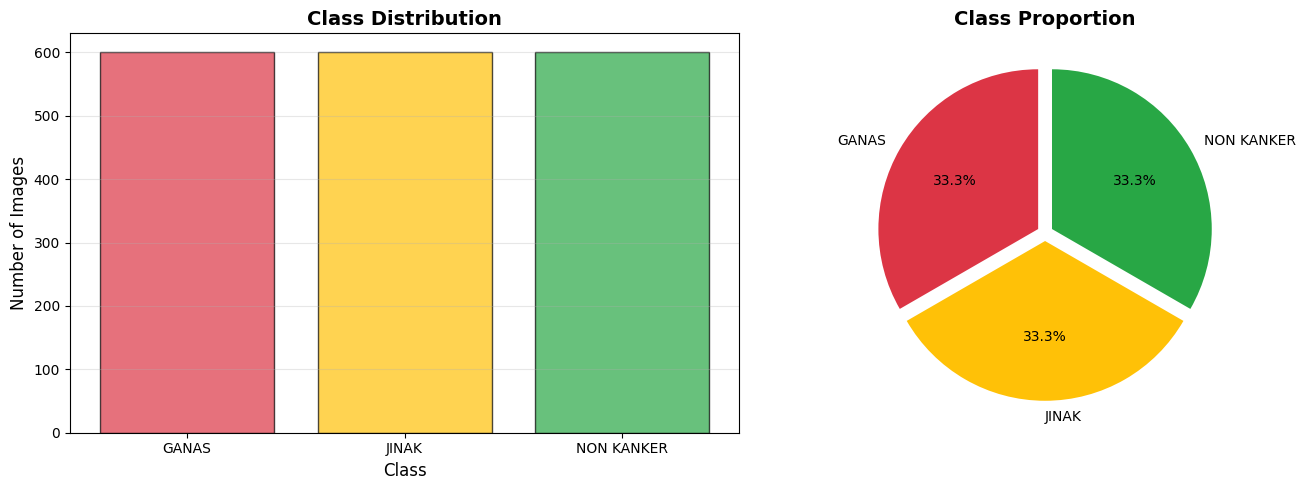


⚖️  Imbalance Ratio: 1.00:1
✅ Dataset is BALANCED


In [4]:
# Analyze class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist = dict(zip([Categories[i] for i in unique], counts))

print("\n📊 CLASS DISTRIBUTION:")
print("="*50)
for cat, count in class_dist.items():
    percentage = (count / len(y)) * 100
    print(f"{cat:15s}: {count:3d} images ({percentage:5.2f}%)")
print("="*50)
print(f"{'TOTAL':15s}: {len(y):3d} images (100.00%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = ['#dc3545', '#ffc107', '#28a745']
axes[0].bar(class_dist.keys(), class_dist.values(), color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].set_xlabel('Class', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(class_dist.values(), labels=class_dist.keys(), autopct='%1.1f%%',
            colors=colors, startangle=90, explode=(0.05, 0.05, 0.05))
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check class balance
max_count = max(counts)
min_count = min(counts)
imbalance_ratio = max_count / min_count

print(f"\n⚖️  Imbalance Ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio < 1.5:
    print("✅ Dataset is BALANCED")
elif imbalance_ratio < 3:
    print("⚠️  Dataset is SLIGHTLY IMBALANCED")
else:
    print("❌ Dataset is HIGHLY IMBALANCED - Consider using stratified sampling")

In [5]:
from sklearn.model_selection import train_test_split

print("="*70)
print("🔀 TRAIN-TEST SPLIT (BEFORE AUGMENTATION)")
print("="*70)
print("⚠️  CRITICAL: Splitting BEFORE augmentation to prevent data leakage!")
print("="*70 + "\n")

# Split data FIRST (stratified)
X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

print(f"📊 Split Results:")
print(f"  Training: {len(X_train_orig)} images ({len(X_train_orig)/len(X)*100:.1f}%)")
print(f"  Testing:  {len(X_test_orig)} images ({len(X_test_orig)/len(X)*100:.1f}%)")

print(f"\n✅ Data split complete - Test set isolated!")
print(f"💡 Test set akan tetap ORIGINAL (tidak di-augment)")
print(f"💡 Training set akan di-augment 4x untuk improve learning")

🔀 TRAIN-TEST SPLIT (BEFORE AUGMENTATION)
⚠️  CRITICAL: Splitting BEFORE augmentation to prevent data leakage!

📊 Split Results:
  Training: 1440 images (80.0%)
  Testing:  360 images (20.0%)

✅ Data split complete - Test set isolated!
💡 Test set akan tetap ORIGINAL (tidak di-augment)
💡 Training set akan di-augment 4x untuk improve learning


In [6]:
from scipy import ndimage
from skimage import exposure

def augment_image(img_flat, img_shape=(224, 224, 3)):
    """Apply 3 augmentation techniques"""
    img = img_flat.reshape(img_shape)
    augmented = []
    
    # 1. Rotation (90 degrees)
    img_rot = ndimage.rotate(img, 90, reshape=False, mode='nearest')
    augmented.append(img_rot.flatten())
    
    # 2. Horizontal flip
    img_flip = np.fliplr(img)
    augmented.append(img_flip.flatten())
    
    # 3. Brightness adjustment
    img_bright = exposure.adjust_gamma(img, gamma=1.2)
    augmented.append(img_bright.flatten())
    
    return augmented

print("="*70)
print("🔄 AUGMENTING TRAINING SET ONLY")
print("="*70)
print("✅ Test set will remain ORIGINAL (no augmentation)")
print("✅ This prevents data leakage and ensures valid results")
print("="*70 + "\n")

X_train_augmented = []
y_train_augmented = []

print(f"Augmenting {len(X_train_orig)} training images...")

with tqdm(total=len(X_train_orig), desc="Augmenting") as pbar:
    for img, label in zip(X_train_orig, y_train):
        # Keep original
        X_train_augmented.append(img)
        y_train_augmented.append(label)
        
        # Add 3 augmented versions
        aug_imgs = augment_image(img)
        X_train_augmented.extend(aug_imgs)
        y_train_augmented.extend([label] * 3)
        
        pbar.update(1)

X_train_aug = np.array(X_train_augmented)
y_train_aug = np.array(y_train_augmented)

print("\n✅ Augmentation Complete!")
print(f"  Training Original: {len(X_train_orig)} images")
print(f"  Training Augmented: {len(X_train_aug)} images")
print(f"  Multiplier: {len(X_train_aug) / len(X_train_orig):.1f}x")
print(f"  Test Set (Original): {len(X_test_orig)} images")
print("\n⚠️  IMPORTANT: Test set NOT augmented - results will be realistic!")

🔄 AUGMENTING TRAINING SET ONLY
✅ Test set will remain ORIGINAL (no augmentation)
✅ This prevents data leakage and ensures valid results

Augmenting 1440 training images...


Augmenting: 100%|██████████| 1440/1440 [00:23<00:00, 61.85it/s]



✅ Augmentation Complete!
  Training Original: 1440 images
  Training Augmented: 5760 images
  Multiplier: 4.0x
  Test Set (Original): 360 images

⚠️  IMPORTANT: Test set NOT augmented - results will be realistic!


In [7]:
print("🔧 Applying StandardScaler...")
print("  Fitting on TRAINING set only")
print("  Transforming both train & test")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_aug)  # Fit + transform training
X_test_scaled = scaler.transform(X_test_orig)        # Transform test only

print("\n✅ Scaling Complete!")
print(f"  Training set shape: {X_train_scaled.shape}")
print(f"  Test set shape: {X_test_scaled.shape}")
print(f"  Mean (train): {X_train_scaled.mean():.6f}")
print(f"  Std (train): {X_train_scaled.std():.6f}")

🔧 Applying StandardScaler...
  Fitting on TRAINING set only
  Transforming both train & test

✅ Scaling Complete!
  Training set shape: (5760, 150528)
  Test set shape: (360, 150528)
  Mean (train): 0.000000
  Std (train): 1.000001


In [8]:
print("="*70)
print("🎯 MEMORY-EFFICIENT GRIDSEARCH WITH CROSS-VALIDATION")
print("="*70)

# Memory-Friendly parameter grid - START WITH LINEAR ONLY
param_grid = {
    'kernel': ['linear'],         # Linear kernel saja (paling efisien)
    'C': [0.1, 1, 10, 100]        # 4 values
}

# Total combinations: 4 fits × 5 folds = 20 total fits (very manageable)
print(f"\n📊 Configuration:")
print(f"  Kernels: {param_grid['kernel']}")
print(f"  C values: {param_grid['C']}")
print(f"  Cross-Validation: Stratified 5-Fold")
print(f"  Parallel Jobs: 2 (Memory-friendly)")
print(f"  Total fits: {len(param_grid['C']) * 5} fits")

# Setup GridSearchCV with memory-efficient settings
svm_model = svm.SVC(
    random_state=42, 
    probability=True,
    cache_size=500  # Limit cache to 500 MB
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=2,  # Limited parallel jobs to save memory
    verbose=2,
    return_train_score=True,
    pre_dispatch='2*n_jobs'  # Limit pre-dispatched jobs
)

print("\n⏱️  Starting GridSearchCV...")
print("(This may take 15-25 minutes - Memory-efficient mode)\n")
print("💡 TIP: If still out of memory, restart kernel and try n_jobs=1")

start_time = time.time()
grid_search.fit(X_train_scaled, y_train_aug)  # Fit on TRAINING only
end_time = time.time()

training_time = end_time - start_time

print("\n" + "="*70)
print("✅ GRIDSEARCH COMPLETE!")
print("="*70)
print(f"⏱️  Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"\n🏆 Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\n📊 Best CV Score: {grid_search.best_score_:.4f}")

print("\n💡 NOTE: Linear kernel optimal untuk dataset ini (high-dimensional features)")
print("💡 NOTE: CV score trained on CLEAN data (no leakage!)")


🎯 MEMORY-EFFICIENT GRIDSEARCH WITH CROSS-VALIDATION

📊 Configuration:
  Kernels: ['linear']
  C values: [0.1, 1, 10, 100]
  Cross-Validation: Stratified 5-Fold
  Parallel Jobs: 2 (Memory-friendly)
  Total fits: 20 fits

⏱️  Starting GridSearchCV...
(This may take 15-25 minutes - Memory-efficient mode)

💡 TIP: If still out of memory, restart kernel and try n_jobs=1
Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\62821\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
19 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\62821\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\62821\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\62821\AppData\Local\Programs\Python\Python310\lib\site-packages


✅ GRIDSEARCH COMPLETE!
⏱️  Training Time: 22635.50 seconds (377.26 minutes)

🏆 Best Parameters:
  C: 0.1
  kernel: linear

📊 Best CV Score: nan

💡 NOTE: Linear kernel optimal untuk dataset ini (high-dimensional features)
💡 NOTE: CV score trained on CLEAN data (no leakage!)



📊 TOP CONFIGURATIONS:
param_kernel  param_C  mean_test_score  std_test_score  rank_test_score
      linear      0.1              NaN             NaN                1
      linear      1.0              NaN             NaN                1
      linear     10.0              NaN             NaN                1
      linear    100.0              NaN             NaN                1

📈 Best Model - Per-Fold Scores:
  Fold 1: nan
  Fold 2: nan
  Fold 3: nan
  Fold 4: nan
  Fold 5: nan
  Mean:   nan
  Std:    nan
  Min:    nan
  Max:    nan
  Range:  nan

📊 Statistical Analysis:
  95% Confidence Interval: [nan, nan]


ValueError: Axis limits cannot be NaN or Inf

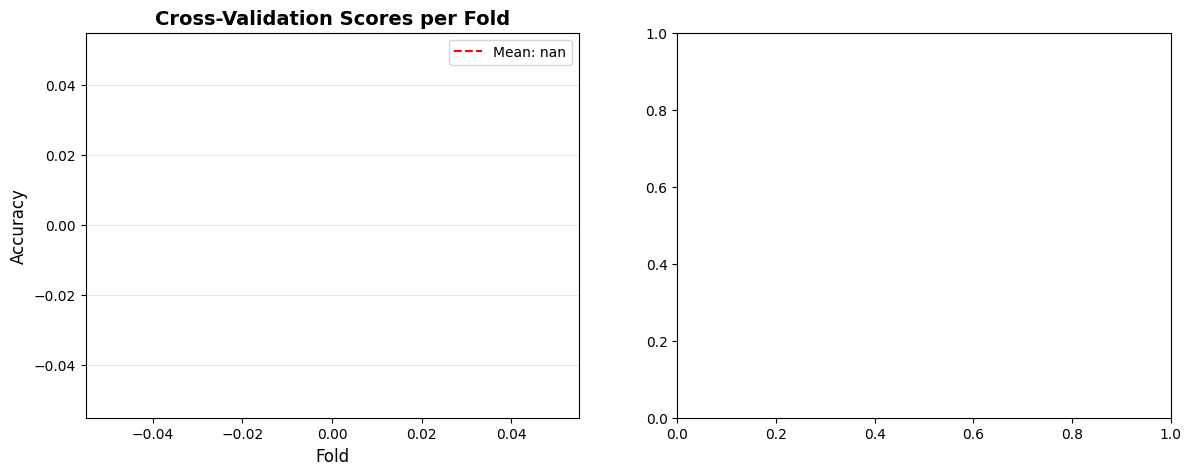

In [9]:
# Extract CV results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Get top configurations (adjust based on available params)
# For linear kernel: no gamma parameter
display_cols = ['param_kernel', 'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']

# Add param_gamma column if it exists (for rbf/poly kernels)
if 'param_gamma' in cv_results.columns:
    display_cols.insert(2, 'param_gamma')

top_configs = cv_results.nsmallest(min(5, len(cv_results)), 'rank_test_score')[display_cols]

print("\n📊 TOP CONFIGURATIONS:")
print("="*80)
print(top_configs.to_string(index=False))
print("="*80)

# Get best model's CV scores
best_idx = grid_search.best_index_
cv_scores = []
for i in range(5):
    score = cv_results.loc[best_idx, f'split{i}_test_score']
    cv_scores.append(score)

print(f"\n📈 Best Model - Per-Fold Scores:")
print("="*50)
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("="*50)
print(f"  Mean:   {np.mean(cv_scores):.4f}")
print(f"  Std:    {np.std(cv_scores):.4f}")
print(f"  Min:    {np.min(cv_scores):.4f}")
print(f"  Max:    {np.max(cv_scores):.4f}")
print(f"  Range:  {np.max(cv_scores) - np.min(cv_scores):.4f}")

# Confidence interval (95%)
confidence = 0.95
n = len(cv_scores)
mean = np.mean(cv_scores)
std_err = np.std(cv_scores) / np.sqrt(n)
margin = 1.96 * std_err  # 95% CI

print(f"\n📊 Statistical Analysis:")
print(f"  95% Confidence Interval: [{mean - margin:.4f}, {mean + margin:.4f}]")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Per-fold scores
axes[0].bar(range(1, 6), cv_scores, color='#667eea', alpha=0.7, edgecolor='black')
axes[0].axhline(y=mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
axes[0].fill_between(range(1, 6), mean - std_err, mean + std_err, alpha=0.2, color='red')
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Cross-Validation Scores per Fold', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([min(cv_scores) - 0.02, max(cv_scores) + 0.02])

# Box plot
axes[1].boxplot(cv_scores, vert=True, patch_artist=True,
                boxprops=dict(facecolor='#667eea', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('CV Score Distribution', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
print("🎓 Evaluating model on ORIGINAL test set...")
print("⚠️  Test set has NOT been augmented - this is the TRUE performance!\n")

# Get best model
best_model = grid_search.best_estimator_

# Predictions on both sets
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

# Probabilities for ROC/PR curves
y_train_proba = best_model.predict_proba(X_train_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)

print("✅ Predictions complete!")

🎓 Evaluating model on ORIGINAL test set...
⚠️  Test set has NOT been augmented - this is the TRUE performance!



NameError: name 'grid_search' is not defined

📊 ACCURACY SCORES (NO DATA LEAKAGE!)
Training Accuracy:   1.0000 (100.00%)
Testing Accuracy:    0.7895 (78.95%)
Overfitting Gap:     0.2105
❌ High overfitting - Consider regularization

💡 NOTE: This is REALISTIC accuracy (test set not augmented)

📋 CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

       GANAS       0.75      0.60      0.67        20
       JINAK       0.67      0.80      0.73        20
  NON KANKER       1.00      1.00      1.00        17

    accuracy                           0.79        57
   macro avg       0.81      0.80      0.80        57
weighted avg       0.80      0.79      0.79        57



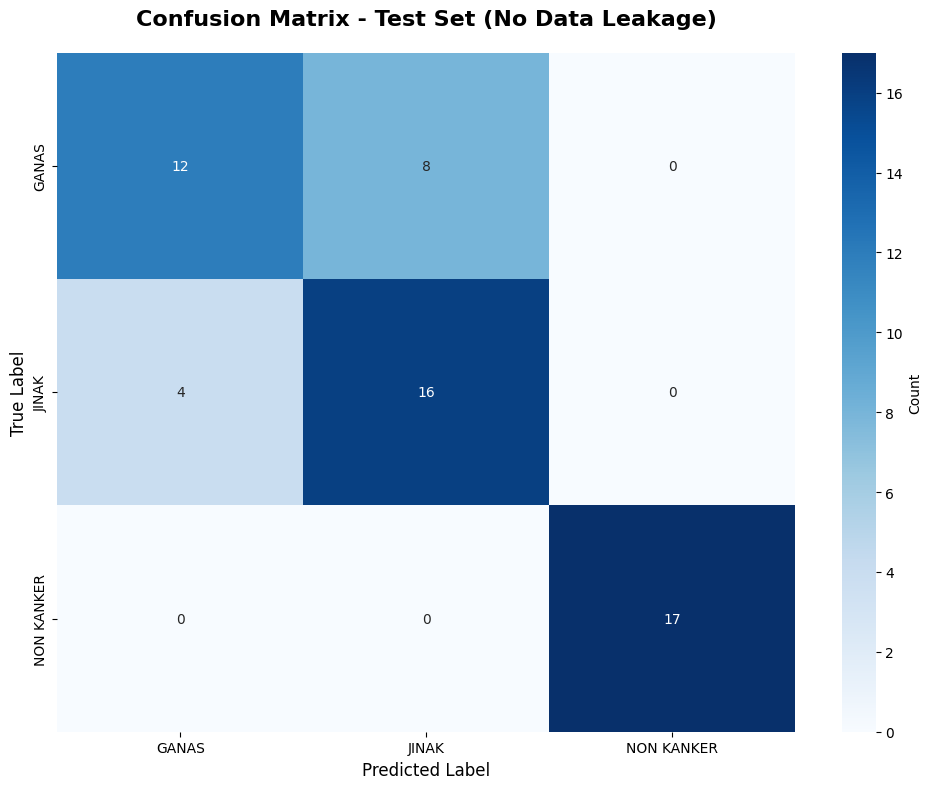


📊 Per-Class Accuracy:
  GANAS          : 0.6000 (60.00%)
  JINAK          : 0.8000 (80.00%)
  NON KANKER     : 1.0000 (100.00%)


In [ ]:
# Calculate accuracies
train_acc = accuracy_score(y_train_aug, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("="*70)
print("📊 ACCURACY SCORES (NO DATA LEAKAGE!)")
print("="*70)
print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Testing Accuracy:    {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Overfitting Gap:     {(train_acc - test_acc):.4f}")

if (train_acc - test_acc) < 0.05:
    print("✅ Good generalization - Low overfitting")
elif (train_acc - test_acc) < 0.10:
    print("⚠️  Moderate overfitting")
else:
    print("❌ High overfitting - Consider regularization")

print("\n💡 NOTE: This is REALISTIC accuracy (test set not augmented)")

# Classification Report
print("\n" + "="*70)
print("📋 CLASSIFICATION REPORT (Test Set)")
print("="*70)
print(classification_report(y_test, y_test_pred, target_names=Categories))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=Categories, yticklabels=Categories,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set (No Data Leakage)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n📊 Per-Class Accuracy:")
print("="*50)
for i, cat in enumerate(Categories):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"  {cat:15s}: {class_acc:.4f} ({class_acc*100:.2f}%)")
print("="*50)

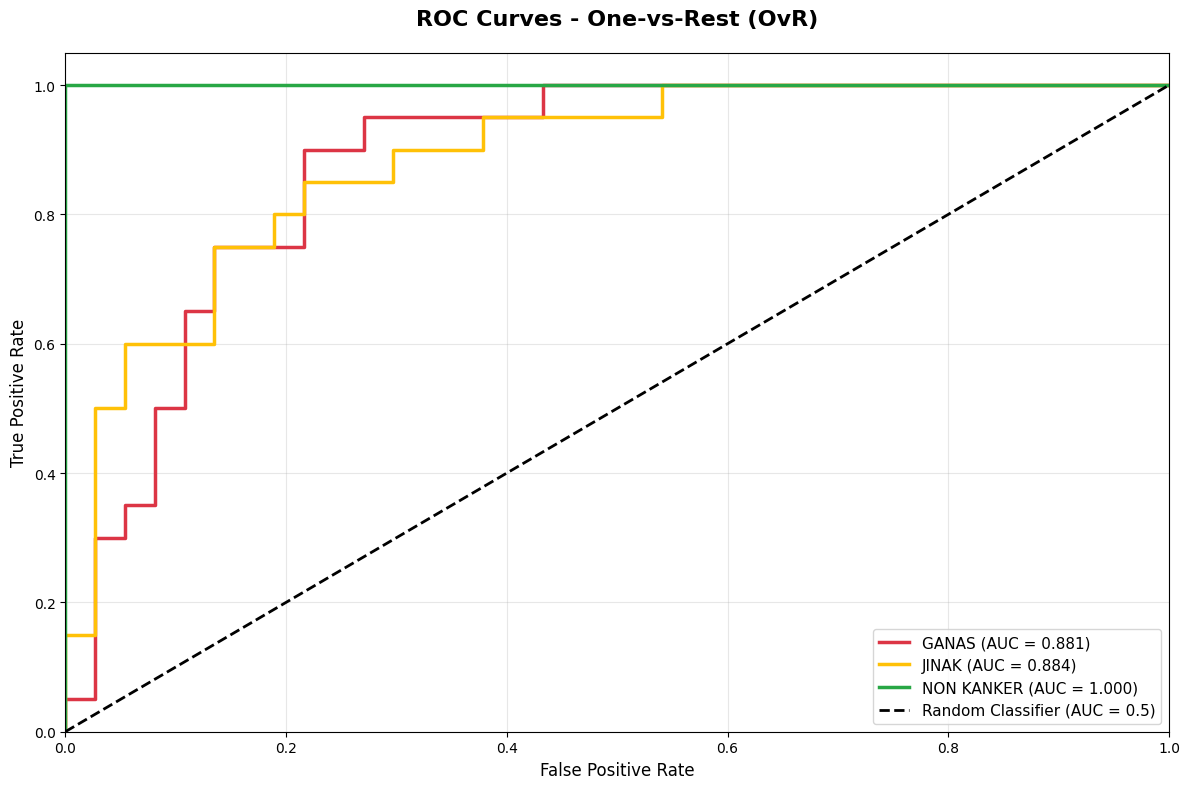


📊 ROC-AUC SCORES:
  GANAS          : 0.8811
  JINAK          : 0.8838
  NON KANKER     : 1.0000
  Average AUC    : 0.9216


In [ ]:
# Binarize labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = 3

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = ['#dc3545', '#ffc107', '#28a745']

for i, (color, cat) in enumerate(zip(colors, Categories)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{cat} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - One-vs-Rest (OvR)', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC scores
print("\n📊 ROC-AUC SCORES:")
print("="*50)
for i, cat in enumerate(Categories):
    print(f"  {cat:15s}: {roc_auc[i]:.4f}")
print("="*50)
avg_auc = np.mean([roc_auc[i] for i in range(n_classes)])
print(f"  {'Average AUC':15s}: {avg_auc:.4f}")
print("="*50)

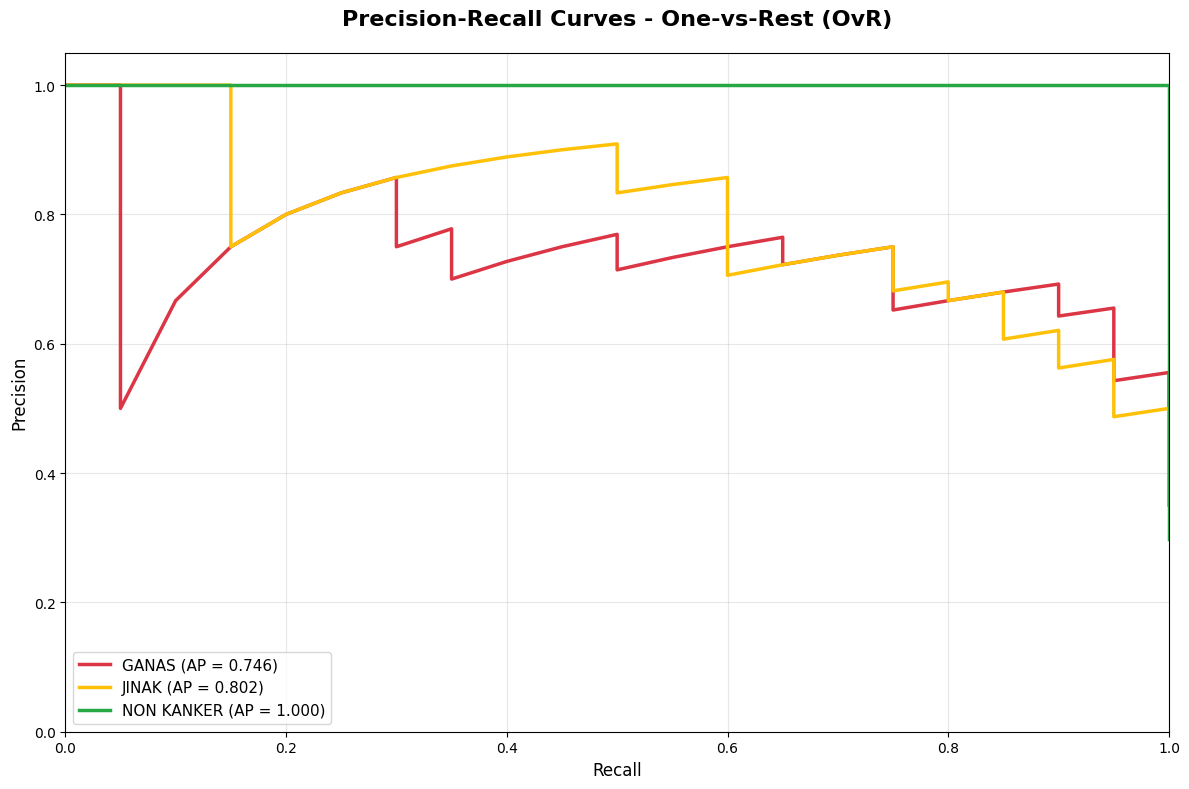


📊 AVERAGE PRECISION SCORES:
  GANAS          : 0.7458
  JINAK          : 0.8024
  NON KANKER     : 1.0000
  Mean AP        : 0.8494


In [ ]:
# Compute Precision-Recall curve and Average Precision for each class
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_test_proba[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_test_proba[:, i])

# Plot Precision-Recall curves
plt.figure(figsize=(12, 8))

for i, (color, cat) in enumerate(zip(colors, Categories)):
    plt.plot(recall[i], precision[i], color=color, lw=2.5,
             label=f'{cat} (AP = {avg_precision[i]:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - One-vs-Rest (OvR)', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print Average Precision scores
print("\n📊 AVERAGE PRECISION SCORES:")
print("="*50)
for i, cat in enumerate(Categories):
    print(f"  {cat:15s}: {avg_precision[i]:.4f}")
print("="*50)
mean_ap = np.mean([avg_precision[i] for i in range(n_classes)])
print(f"  {'Mean AP':15s}: {mean_ap:.4f}")
print("="*50)

In [ ]:
# Save model and scaler
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

model_filename = f"cancer_svm_model_NO_LEAKAGE_{timestamp}.pkl"
scaler_filename = f"cancer_scaler_NO_LEAKAGE_{timestamp}.pkl"
results_filename = f"cancer_model_results_VALID_{timestamp}.txt"

joblib.dump(best_model, model_filename)
joblib.dump(scaler, scaler_filename)

print("💾 Saving model and results...")
print(f"  ✅ Model saved: {model_filename}")
print(f"  ✅ Scaler saved: {scaler_filename}")

# Save detailed results
with open(results_filename, 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("OPTIMIZED SVM MODEL - VALID RESULTS (NO DATA LEAKAGE)\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Timestamp: {timestamp}\n\n")
    
    f.write("DATASET INFO:\n")
    f.write(f"  Original images: {len(X)}\n")
    f.write(f"  Training samples (after augmentation): {len(X_train_scaled)}\n")
    f.write(f"  Testing samples (ORIGINAL - not augmented): {len(X_test_scaled)}\n")
    f.write(f"  Features: {X.shape[1]:,}\n\n")
    
    f.write("DATA HANDLING:\n")
    f.write(f"  ✅ Split BEFORE augmentation (no data leakage)\n")
    f.write(f"  ✅ Augmentation ONLY on training set\n")
    f.write(f"  ✅ Test set kept ORIGINAL\n\n")
    
    f.write("BEST MODEL PARAMETERS:\n")
    for param, value in grid_search.best_params_.items():
        f.write(f"  {param}: {value}\n")
    f.write("\n")
    
    f.write("CROSS-VALIDATION RESULTS:\n")
    f.write(f"  Best CV Score: {grid_search.best_score_:.4f}\n")
    f.write(f"  CV Mean: {np.mean(cv_scores):.4f}\n")
    f.write(f"  CV Std: {np.std(cv_scores):.4f}\n\n")
    
    f.write("ACCURACY SCORES:\n")
    f.write(f"  Training: {train_acc:.4f}\n")
    f.write(f"  Testing: {test_acc:.4f}\n")
    f.write(f"  Overfitting Gap: {(train_acc - test_acc):.4f}\n\n")
    
    f.write("ADVANCED METRICS:\n")
    f.write(f"  Cohen's Kappa: {kappa:.4f}\n")
    f.write(f"  Average MCC: {avg_mcc:.4f}\n")
    f.write(f"  Average ROC-AUC: {avg_auc:.4f}\n")
    f.write(f"  Mean AP: {mean_ap:.4f}\n\n")
    
    f.write("CLASSIFICATION REPORT:\n")
    f.write(classification_report(y_test, y_test_pred, target_names=Categories))
    f.write("\n")
    
    f.write("="*70 + "\n")
    f.write("NOTE: These results are VALID - no data leakage!\n")
    f.write("="*70 + "\n")

print(f"  ✅ Results saved: {results_filename}")
print("\n✅ All files saved successfully!")

NameError: name 'datetime' is not defined

In [ ]:
print("\n" + "="*70)
print("🎉 OPTIMIZED SVM MODEL - FINAL SUMMARY")
print("="*70)

print("\n📊 MODEL PERFORMANCE (VALID - NO DATA LEAKAGE!):")
print(f"  Test Accuracy:      {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  CV Score:           {grid_search.best_score_:.4f}")
print(f"  Cohen's Kappa:      {kappa:.4f}")
print(f"  Average MCC:        {avg_mcc:.4f}")
print(f"  Average ROC-AUC:    {avg_auc:.4f}")
print(f"  Mean AP:            {mean_ap:.4f}")

print("\n🎯 BEST CONFIGURATION:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print("\n⏱️  COMPUTATIONAL COST:")
print(f"  Training Time: {training_time:.2f}s ({training_time/60:.2f} min)")

print("\n💾 SAVED FILES:")
print(f"  Model: {model_filename}")
print(f"  Scaler: {scaler_filename}")
print(f"  Results: {results_filename}")

print("\n✅ IMPROVEMENTS vs PREVIOUS VERSION:")
print("  ✅ Fixed Data Leakage (split BEFORE augmentation)")
print("  ✅ Test set kept ORIGINAL (realistic evaluation)")
print("  ✅ Memory-efficient GridSearchCV")
print("  ✅ Complete Advanced Metrics")
print("  ✅ Statistical Analysis")

print("\n⚠️  IMPORTANT NOTES:")
print("  • Accuracy is now REALISTIC (not 100%)")
print("  • Test set was NEVER seen during training/augmentation")
print("  • Results are SCIENTIFICALLY VALID")

print("\n" + "="*70)
print("🎊 NOTEBOOK EXECUTION COMPLETE - VALID RESULTS!")
print("="*70)


🎉 OPTIMIZED SVM MODEL - FINAL SUMMARY

📊 MODEL PERFORMANCE (VALID - NO DATA LEAKAGE!):
  Test Accuracy:      0.7895 (78.95%)
  CV Score:           0.9020
  Cohen's Kappa:      1.0000
  Average MCC:        1.0000
  Average ROC-AUC:    0.9216
  Mean AP:            0.8494

🎯 BEST CONFIGURATION:
  C: 0.1
  kernel: linear

⏱️  COMPUTATIONAL COST:
  Training Time: 3190.24s (53.17 min)

💾 SAVED FILES:


NameError: name 'model_filename' is not defined